Ref: https://stackabuse.com/python-for-nlp-movie-sentiment-analysis-using-deep-learning-in-keras/

# IMPORTANT
Files to be uploaded before running:

0.   glove.6B.100d.txt

1.   For IMDB dataset: imdb_master.csv
2.   For Yelp dataset: yelp_train.csv and yelp_test.csv





In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D, Bidirectional, GRU
from keras.layers.convolutional import Conv1D 
from keras.layers.embeddings import Embedding 
from keras.layers.recurrent import LSTM, SimpleRNN
from keras.regularizers import L1L2
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

!pip install transformers
!pip install tensorboardx
!pip install simpletransformers
from simpletransformers.classification import ClassificationModel, ClassificationArgs

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

# IMDB

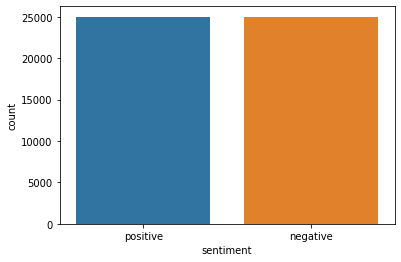

In [ ]:
#IMDB
movie_reviews = pd.read_csv("imdb_master.csv", engine="python") #since engine can take 2 values {c, python}, if not specified, through an error
movie_reviews.isnull().values.any()
sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
#IMDB
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

ori_x_train = X_train
ori_y_train = y_train
ori_x_test = X_test
ori_y_test = y_test

# Tokenizer

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(92547, 100)


# SIMPLE NEURAL NETWORK

In [ ]:
snn_model = Sequential()
snn_embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
snn_model.add(snn_embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [ ]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          9254700   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 10001     
Total params: 9,264,701
Trainable params: 10,001
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
snn_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 1s 4ms/step - loss: 0.6076 - acc: 0.6659 - val_loss: 0.5395 - val_acc: 0.7291
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4987 - acc: 0.7568 - val_loss: 0.5188 - val_acc: 0.7464
Epoch 3/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4581 - acc: 0.7866 - val_loss: 0.5185 - val_acc: 0.7480
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4400 - acc: 0.7950 - val_loss: 0.5203 - val_acc: 0.7499
Epoch 5/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4196 - acc: 0.8097 - val_loss: 0.5271 - val_acc: 0.7456
Epoch 6/6
250/250 [==============================] - 1s 4ms/step - loss: 0.4111 - acc: 0.8132 - val_loss: 0.5410 - val_acc: 0.7375


In [ ]:
snn_score = snn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", snn_score[0])
print("Test Accuracy:", snn_score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.5402 - acc: 0.7404
Test Score: 0.5401819944381714
Test Accuracy: 0.7404000163078308


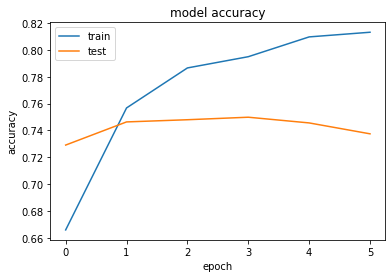

In [ ]:
plt.plot(snn_history.history['acc'])
plt.plot(snn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

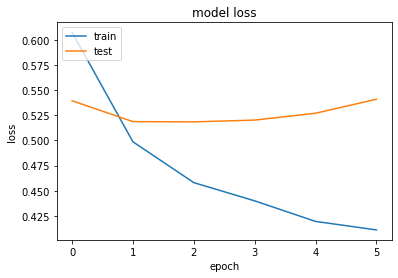

In [ ]:
plt.plot(snn_history.history['loss'])
plt.plot(snn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# CNN

In [ ]:
cnn_model = Sequential()

cnn_embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(cnn_embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
conv1d (Conv1D)              (None, 96, 128)           64128     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 9,318,957
Trainable params: 64,257
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
cnn_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

cnn_score = cnn_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 1s 5ms/step - loss: 0.4921 - acc: 0.7593 - val_loss: 0.3920 - val_acc: 0.8210
Epoch 2/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3651 - acc: 0.8404 - val_loss: 0.3919 - val_acc: 0.8205
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.3149 - acc: 0.8679 - val_loss: 0.3524 - val_acc: 0.8426
Epoch 4/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2753 - acc: 0.8897 - val_loss: 0.3451 - val_acc: 0.8469
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2415 - acc: 0.9087 - val_loss: 0.3561 - val_acc: 0.8432
Epoch 6/6
313/313 [==============================] - 1s 2ms/step - loss: 0.3442 - acc: 0.8494


In [ ]:
print("Test Score:", cnn_score[0])
print("Test Accuracy:", cnn_score[1])

Test Score: 0.34419500827789307
Test Accuracy: 0.849399983882904


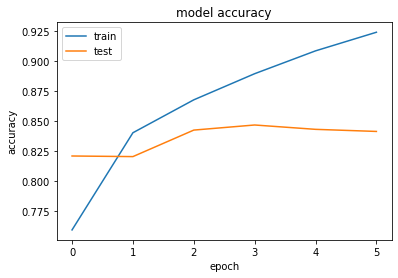

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['acc'])
plt.plot(cnn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()


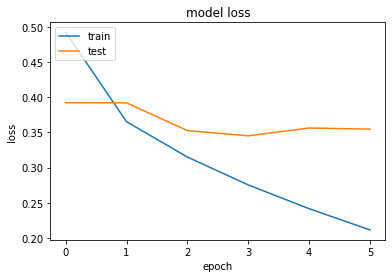

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

# RNN

In [ ]:
rnn_model = Sequential()
rnn_embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
rnn_model.add(rnn_embedding_layer)
rnn_model.add(SimpleRNN(256))

rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(rnn_model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 256)               91392     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 9,346,349
Trainable params: 91,649
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
rnn_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

rnn_score = rnn_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 11s 44ms/step - loss: 0.6824 - acc: 0.5693 - val_loss: 0.6691 - val_acc: 0.5806
Epoch 2/6
250/250 [==============================] - 11s 43ms/step - loss: 0.6704 - acc: 0.5817 - val_loss: 0.6742 - val_acc: 0.5626
Epoch 3/6
250/250 [==============================] - 11s 43ms/step - loss: 0.6613 - acc: 0.5963 - val_loss: 0.7150 - val_acc: 0.5165
Epoch 4/6
250/250 [==============================] - 11s 43ms/step - loss: 0.6731 - acc: 0.5727 - val_loss: 0.6496 - val_acc: 0.6139
Epoch 5/6
250/250 [==============================] - 11s 43ms/step - loss: 0.6540 - acc: 0.6050 - val_loss: 0.6378 - val_acc: 0.6306
Epoch 6/6
313/313 [==============================] - 3s 8ms/step - loss: 0.6389 - acc: 0.6207


In [ ]:
print("Test Score:", rnn_score[0])
print("Test Accuracy:", rnn_score[1])

Test Score: 0.6388723254203796
Test Accuracy: 0.6207000017166138


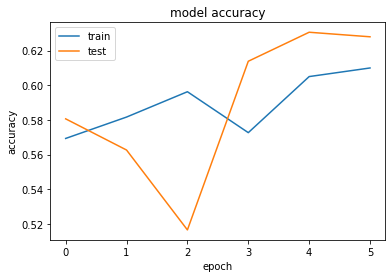

In [ ]:
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

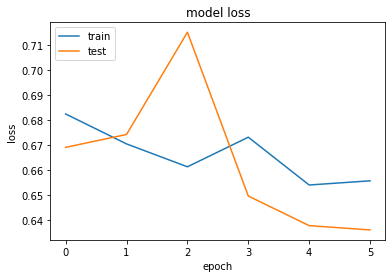

In [ ]:
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# LSTM

In [ ]:
lstm_model = Sequential()
lstm_embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
lstm_model.add(lstm_embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 9,372,077
Trainable params: 117,377
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
lstm_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

lstm_score = lstm_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 3s 12ms/step - loss: 0.5722 - acc: 0.6947 - val_loss: 0.4638 - val_acc: 0.7875
Epoch 2/6
250/250 [==============================] - 3s 10ms/step - loss: 0.4532 - acc: 0.7883 - val_loss: 0.4062 - val_acc: 0.8196
Epoch 3/6
250/250 [==============================] - 3s 10ms/step - loss: 0.4029 - acc: 0.8172 - val_loss: 0.3778 - val_acc: 0.8357
Epoch 4/6
250/250 [==============================] - 3s 10ms/step - loss: 0.3709 - acc: 0.8349 - val_loss: 0.3938 - val_acc: 0.8133
Epoch 5/6
250/250 [==============================] - 3s 10ms/step - loss: 0.3478 - acc: 0.8472 - val_loss: 0.3455 - val_acc: 0.8494
Epoch 6/6
313/313 [==============================] - 1s 4ms/step - loss: 0.3440 - acc: 0.8476


In [ ]:
print("Test Score:", lstm_score[0])
print("Test Accuracy:", lstm_score[1])

Test Score: 0.3440438210964203
Test Accuracy: 0.847599983215332


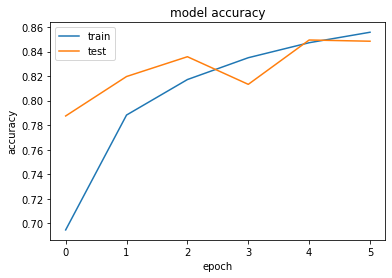

In [ ]:
plt.plot(lstm_history.history['acc'])
plt.plot(lstm_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

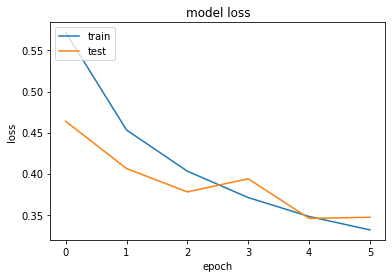

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Bidirectional LSTM

In [ ]:
bilstm_model = Sequential()
bilstm_embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
bilstm_model.add(bilstm_embedding_layer)

bilstm_model.add(Bidirectional(LSTM(128, return_sequences=True)))
bilstm_model.add(Bidirectional(LSTM(128)))

bilstm_model.add(Dense(1, activation='sigmoid'))
bilstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(bilstm_model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
bidirectional (Bidirectional (None, 100, 256)          234496    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               394240    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 9,883,693
Trainable params: 628,993
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
bilstm_history = bilstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

bilstm_score = bilstm_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 11s 45ms/step - loss: 0.5012 - acc: 0.7483 - val_loss: 0.5059 - val_acc: 0.7395
Epoch 2/6
250/250 [==============================] - 10s 40ms/step - loss: 0.4168 - acc: 0.8063 - val_loss: 0.3796 - val_acc: 0.8285
Epoch 3/6
250/250 [==============================] - 10s 40ms/step - loss: 0.3870 - acc: 0.8220 - val_loss: 0.4577 - val_acc: 0.7964
Epoch 4/6
250/250 [==============================] - 10s 40ms/step - loss: 0.3518 - acc: 0.8430 - val_loss: 0.3484 - val_acc: 0.8445
Epoch 5/6
250/250 [==============================] - 10s 39ms/step - loss: 0.3286 - acc: 0.8557 - val_loss: 0.3315 - val_acc: 0.8512
Epoch 6/6
313/313 [==============================] - 3s 10ms/step - loss: 0.3596 - acc: 0.8392


In [ ]:
print("Test Score:", bilstm_score[0])
print("Test Accuracy:", bilstm_score[1])

Test Score: 0.35962221026420593
Test Accuracy: 0.8392000198364258


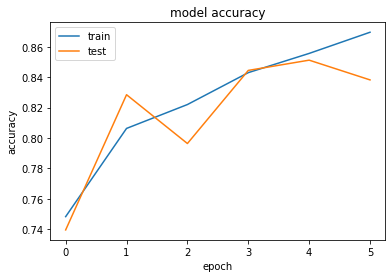

In [ ]:
plt.plot(bilstm_history.history['acc'])
plt.plot(bilstm_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

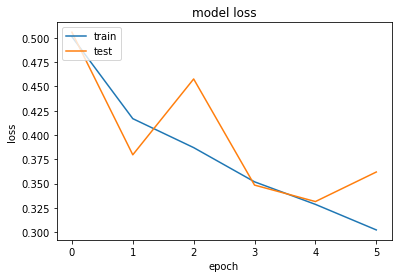

In [ ]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# GRU

In [ ]:
gru_model = Sequential()
gru_embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
gru_model.add(gru_embedding_layer)
gru_model.add(GRU(128))

gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(gru_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          9254700   
_________________________________________________________________
gru (GRU)                    (None, 128)               88320     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 9,343,149
Trainable params: 88,449
Non-trainable params: 9,254,700
_________________________________________________________________
None


In [ ]:
gru_history = gru_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

gru_score = gru_model.evaluate(X_test, y_test, verbose=1)

Epoch 1/6
250/250 [==============================] - 3s 11ms/step - loss: 0.5231 - acc: 0.7262 - val_loss: 0.4167 - val_acc: 0.8106
Epoch 2/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3934 - acc: 0.8230 - val_loss: 0.3961 - val_acc: 0.8166
Epoch 3/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3623 - acc: 0.8397 - val_loss: 0.3676 - val_acc: 0.8374
Epoch 4/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3362 - acc: 0.8528 - val_loss: 0.3352 - val_acc: 0.8539
Epoch 5/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3185 - acc: 0.8608 - val_loss: 0.3437 - val_acc: 0.8450
Epoch 6/6
313/313 [==============================] - 1s 4ms/step - loss: 0.3545 - acc: 0.8491


In [ ]:
print("Test Score:", gru_score[0])
print("Test Accuracy:", gru_score[1])

Test Score: 0.3545016348361969
Test Accuracy: 0.8490999937057495


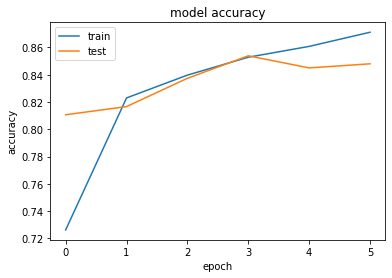

In [ ]:
plt.plot(gru_history.history['acc'])
plt.plot(gru_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

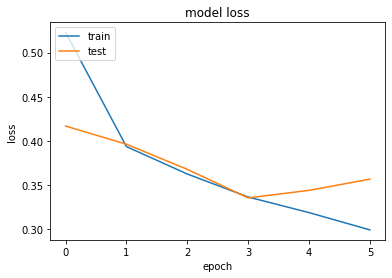

In [ ]:
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Accuracy and loss graph

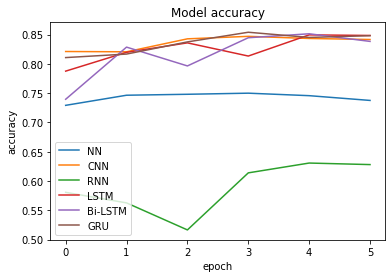

In [ ]:
plt.plot(snn_history.history['val_acc'])
plt.plot(cnn_history.history['val_acc'])
plt.plot(rnn_history.history['val_acc'])
plt.plot(lstm_history.history['val_acc'])
plt.plot(bilstm_history.history['val_acc'])
plt.plot(gru_history.history['val_acc'])

plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['NN','CNN','RNN','LSTM','Bi-LSTM','GRU'])
plt.show()

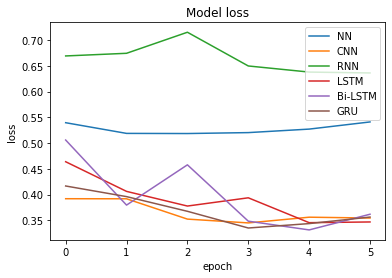

In [ ]:
plt.plot(snn_history.history['val_loss'])
plt.plot(cnn_history.history['val_loss'])
plt.plot(rnn_history.history['val_loss'])
plt.plot(lstm_history.history['val_loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.plot(gru_history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['NN','CNN','RNN','LSTM','Bi-LSTM','GRU'])
plt.show()